In [0]:
from numpy import loadtxt

dataset = loadtxt("https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv", delimiter=",")
x = dataset[:,0:8]
y = dataset[:,8]

In [2]:
x.shape

(768, 8)

In [3]:
y.shape

(768,)

# Otros datasets
https://github.com/jbrownlee/Datasets

In [4]:
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


# Así lo haríamos de normal

In [0]:
def diabetes(X,Y):
    
    model = Sequential()
    model.add(Dense(12, input_dim=8, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X, Y, epochs=100, batch_size=10, verbose=0)
    
    return model

In [6]:
model = diabetes(x,y) 
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12)                108       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 221
Trainable params: 221
Non-trainable params: 0
_________________________________________________________________


# Así lo hacemos con Talos

In [0]:
from keras.activations import relu, elu

p = {
    'first_neuron': [12, 24, 48],
    'activation': [relu, elu],
    'batch_size': [10, 20, 30]
}



In [0]:
# add input parameters to the function
def diabetes(x_train, y_train, x_val, y_val, params):
    
    # replace the hyperparameter inputs with references to params dictionary 
    model = Sequential()
    model.add(Dense(params['first_neuron'], input_dim=8, activation=params['activation']))
    #model.add(Dense(8, activation=params['activation']))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # make sure history object is returned by model.fit()
    out = model.fit(x, y,
                    epochs=100,
                    batch_size=params['batch_size'],
                    #validation_split=.3,
                    verbose=0)
    
    # modify the output model
    return out, model



In [10]:
!pip install talos
import talos as ta

     |████████████████████████████████| 51kB 17.8MB/s 
     |████████████████████████████████| 788kB 7.9MB/s 
     |████████████████████████████████| 12.6MB 41.0MB/s 
  Stored in directory: /root/.cache/pip/wheels/eb/6b/c0/5b58a4767728bb467656ccd70b4fc2e286840c1e8ffa2631ac
  Stored in directory: /root/.cache/pip/wheels/ba/cc/e9/11c6a853d8379f295e17b68f2139ea1bbcd13c5b260822abc7
  Stored in directory: /root/.cache/pip/wheels/61/12/37/957767d4ed95919b90081079c6eb74f83927930e652b30fa93
  Stored in directory: /root/.cache/pip/wheels/36/6b/4c/e1fc6d7d8811940fbea1147b1519c7baa6933e4baeff904433
  Stored in directory: /root/.cache/pip/wheels/76/15/d0/e8ec4c2485b5e4acf35517f32fcdf326e199274cf32690a4ea
Successfully built talos astetik chances kerasplotlib wrangle
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: matplotlib 3.0.3
    Uninstalling matplotlib-3.0.3:
      Successfully uninstalled mat

In [0]:
t = ta.Scan(x, y, p, diabetes)

# ESTRATEGIAS DE OPTIMIZACIÓN

https://autonomio.github.io/docs_talos/#optimization-strategies


Por defecto hace grid search, pero también se puede hacer random. Por ejemplo:

In [0]:
t2 = ta.Scan(x, y, p, diabetes,grid_downsample=.5,random_method='quantum')


100%|██████████| 9/9 [02:30<00:00, 21.58s/it]


Hay otros parámetros: probabilistic reduction, early stopping 

In [11]:
t2 = ta.Scan(x, y, p, diabetes,
             grid_downsample=.2,
             random_method='quantum',
             print_params=True,
             experiment_no='experiment_log',
             dataset_name='pru')

  0%|          | 0/3 [00:00<?, ?it/s]

{'first_neuron': 12, 'activation': <function relu at 0x7f58149801e0>, 'batch_size': 20}


 33%|███▎      | 1/3 [00:13<00:26, 13.32s/it]

{'first_neuron': 24, 'activation': <function elu at 0x7f5814971f28>, 'batch_size': 10}


 67%|██████▋   | 2/3 [00:32<00:14, 14.99s/it]

{'first_neuron': 48, 'activation': <function elu at 0x7f5814971f28>, 'batch_size': 10}


100%|██████████| 3/3 [00:51<00:00, 16.25s/it]


In [12]:
ta.Deploy(t2,'modelo',metric='acc')

Deploy package modelo have been saved.


In [0]:
from keras.models import load_model
rr = ta.Restore('modelo.zip')
model = rr.model

In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 48)                432       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 49        
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________


REPORTING

In [0]:
r = ta.Reporting('pru_experiment_log.csv')


In [16]:
# returns the results dataframe
r.data


,round_epochs,loss,acc,first_neuron,activation,batch_size
0,100,0.542649,0.743490,12,<function relu at 0x7f58149801e0>,20
1,100,0.463062,0.786458,24,<function elu at 0x7f5814971f28>,10
2,100,0.467513,0.798177,48,<function elu at 0x7f5814971f28>,10


In [17]:
# returns the highest value for 'val_fmeasure'
r.high(metric='acc')

0.7981770810050269

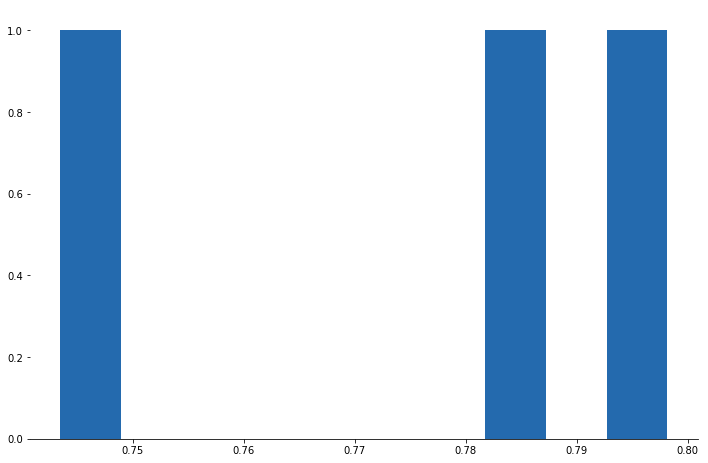

In [18]:
%matplotlib inline
# draws a histogram for 'val_acc'
r.plot_hist(metric='acc')


# Un poco mas complicado

In [0]:
from talos.model.layers import hidden_layers

# add input parameters to the function
def diabetes(x_train, y_train, x_val, y_val, params):
    
    # replace the hyperparameter inputs with references to params dictionary 
    model = Sequential()
    model.add(Dense(params['first_neuron'], input_dim=8, activation=params['activation']))
    hidden_layers(model, params, 1)
    #model.add(Dense(8, activation=params['activation']))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # make sure history object is returned by model.fit()
    out = model.fit(x, y,
                    epochs=100,
                    batch_size=params['batch_size'],
                    #validation_split=.3,
                    verbose=0)
    
    # modify the output model
    return out, model



In [0]:
p = {
    'first_neuron': [12, 24, 48],
    'hidden_layers': [0,1,2],
    'activation': [relu, elu],
    'dropout': (0, 0.5, 5),
    'batch_size': [10, 20, 30]
}


In [0]:
t3 = ta.Scan(x, y, p, diabetes,grid_downsample=.5,random_method='quantum',             
             experiment_no='experiment_3',
             dataset_name='pru')


  0%|          | 0/135 [00:00<?, ?it/s]

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



  5%|▌         | 7/135 [03:02<50:40, 23.76s/it]  

KeyboardInterrupt: ignored

In [0]:
r = ta.Reporting('pru_experiment_3.csv')
# returns the results dataframe
aa = r.data

aa.sort_values('loss')


,round_epochs,loss,acc,first_neuron,hidden_layers,activation,dropout,batch_size
17,100,0.374142,0.828125,48,2,<function elu at 0x7f5087d17158>,0.0,10
117,100,0.375799,0.833333,48,2,<function elu at 0x7f5087d17158>,0.0,10
81,100,0.395605,0.821615,48,2,<function elu at 0x7f5087d17158>,0.0,20
75,100,0.398041,0.826823,48,1,<function elu at 0x7f5087d17158>,0.0,20
67,100,0.403552,0.807292,24,1,<function elu at 0x7f5087d17158>,0.0,10
55,100,0.406737,0.815104,48,1,<function elu at 0x7f5087d17158>,0.0,30
41,100,0.406747,0.816406,24,2,<function elu at 0x7f5087d17158>,0.0,10
115,100,0.432556,0.794271,24,1,<function elu at 0x7f5087d17158>,0.1,10
7,100,0.436009,0.795573,48,2,<function elu at 0x7f5087d17158>,0.2,20
104,100,0.438748,0.790365,48,1,<function elu at 0x7f5087d17158>,0.2,30
